# Analysis 3c: Introspect: Real World Datasets Audio Data Features Importance

Imports, Functs and Paths

In [1]:
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier
from myst_nb import glue
from sklearn.preprocessing import MinMaxScaler
from julearn import run_cross_validation
import joblib
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# plot styles
from sciplotlib import style

import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap

import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

base_save_paper = "./paper_val/"
results_base = "../../results/permutations"
base_dir = "../../"
colors = [
    "#E64B35",
    "#4DBBD5",
    "#00A087",
    "#3C5488",
    "#F39B7F",
    "#8491B4",
    "#91D1C2FF",
    "#DC0000",
    "#7E6148",
    "#B09C85",
]
red = colors[0]
blue = colors[1]
green = colors[2]
purple = colors[5]


def mm_to_inch(val_in_inch):
    mm = 0.1 / 2.54
    return val_in_inch * mm


base_save_paper = "./paper_val/"
results_base = "../../results/"
base_dir = "../../"
audio_data_non_TaCo_folder = f"{results_base}basic_non_TaCo/realistic_non_TaCo/models/"

audio_data_shuffled_non_TaCo_folder = (
    f"{results_base}" "shuffled_features_non_TaCo/realistic_non_TaCo/models/"
)


mpl.style.use(style.get_style("nature-reviews"))
mpl.rc("xtick", labelsize=11)
mpl.rc("ytick", labelsize=11)
mpl.rc("axes", labelsize=12, titlesize=12)
mpl.rc("figure", dpi=300)
mpl.rc("figure.subplot", wspace=mm_to_inch(8), hspace=0.7)
mpl.rc("lines", linewidth=1, markersize=2)

fig = plt.figure(
    figsize=[mm_to_inch(183), mm_to_inch(140)],
)


<Figure size 2161.42x1653.54 with 0 Axes>

Some info on the data:

In [2]:
os.listdir(audio_data_non_TaCo_folder)

df_original = pd.read_csv("../../data/realistic_non_TaCo/audio_data/audio_data_BDI.csv")

# Get the models ready and import data:
X = df_original.filter(regex=".*__continuous$").columns.tolist()
y = "ATT_Task__binary_target"
confounds = ["BDI__continuous_confound"]

model_raw = joblib.load(
    audio_data_non_TaCo_folder + "audio_data_BDI___rf___False___716845___BDI.joblib"
)
model_rem = joblib.load(
    audio_data_non_TaCo_folder + "audio_data_BDI___rf___True___716845___BDI.joblib"
)

model_raw_shuffled = joblib.load(
    audio_data_shuffled_non_TaCo_folder
    + "audio_data_BDI___rf___False___716845___BDI.joblib"
)
model_rem_shuffled = joblib.load(
    audio_data_shuffled_non_TaCo_folder
    + "audio_data_BDI___rf___True___716845___BDI.joblib"
)

# Combine model outputs to heatmap:
df_heat = pd.concat(
    [
        pd.DataFrame(
            dict(
                raw_original=model_raw.named_steps.rf.feature_importances_,
            )
        ),
        pd.DataFrame(
            dict(
                rem_original=model_rem.named_steps.rf.feature_importances_,
            )
        ),
        pd.DataFrame(
            dict(
                raw_shuffled=model_raw_shuffled.named_steps.rf.feature_importances_,
            )
        ),
        pd.DataFrame(
            dict(
                rem_shuffled=model_rem_shuffled.named_steps.rf.feature_importances_,
            )
        ),
    ],
    axis=1,
)

Preprare Feature Importance for Plotting:

In [3]:
df_heat = (
    df_heat.set_axis(X, axis="index")
    .assign(
        rank_raw=lambda df: df.raw_original.rank(ascending=False, method="first"),
        rank_rem=lambda df: df.rem_original.rank(ascending=False, method="first"),
        # Scale Feature Importance to be easy to interpret
        raw_original=lambda df: MinMaxScaler().fit_transform(df[["raw_original"]]),
        rem_original=lambda df: MinMaxScaler().fit_transform(df[["rem_original"]]),
    )
    .pipe(lambda df: df.set_index(df.index.map(lambda x: int(x.split("__")[0]))))
)

most_imp_feat_raw_10 = df_heat.rank_raw.sort_values().iloc[:10].index.to_list()
most_imp_feat_rem_10 = df_heat.rank_rem.sort_values().iloc[:10].index.to_list()

most_important_20 = [*most_imp_feat_raw_10, *most_imp_feat_rem_10]
# Assert Non overlapping
assert len(set(most_important_20)) == 20
vmin, vmax = 0, 1
df_feat_heat_rem = df_heat.loc[most_important_20, ["rem_original", "rank_rem"]]
df_feat_heat_raw = df_heat.loc[most_important_20, ["raw_original", "rank_raw"]]

Plotting Feature Importance

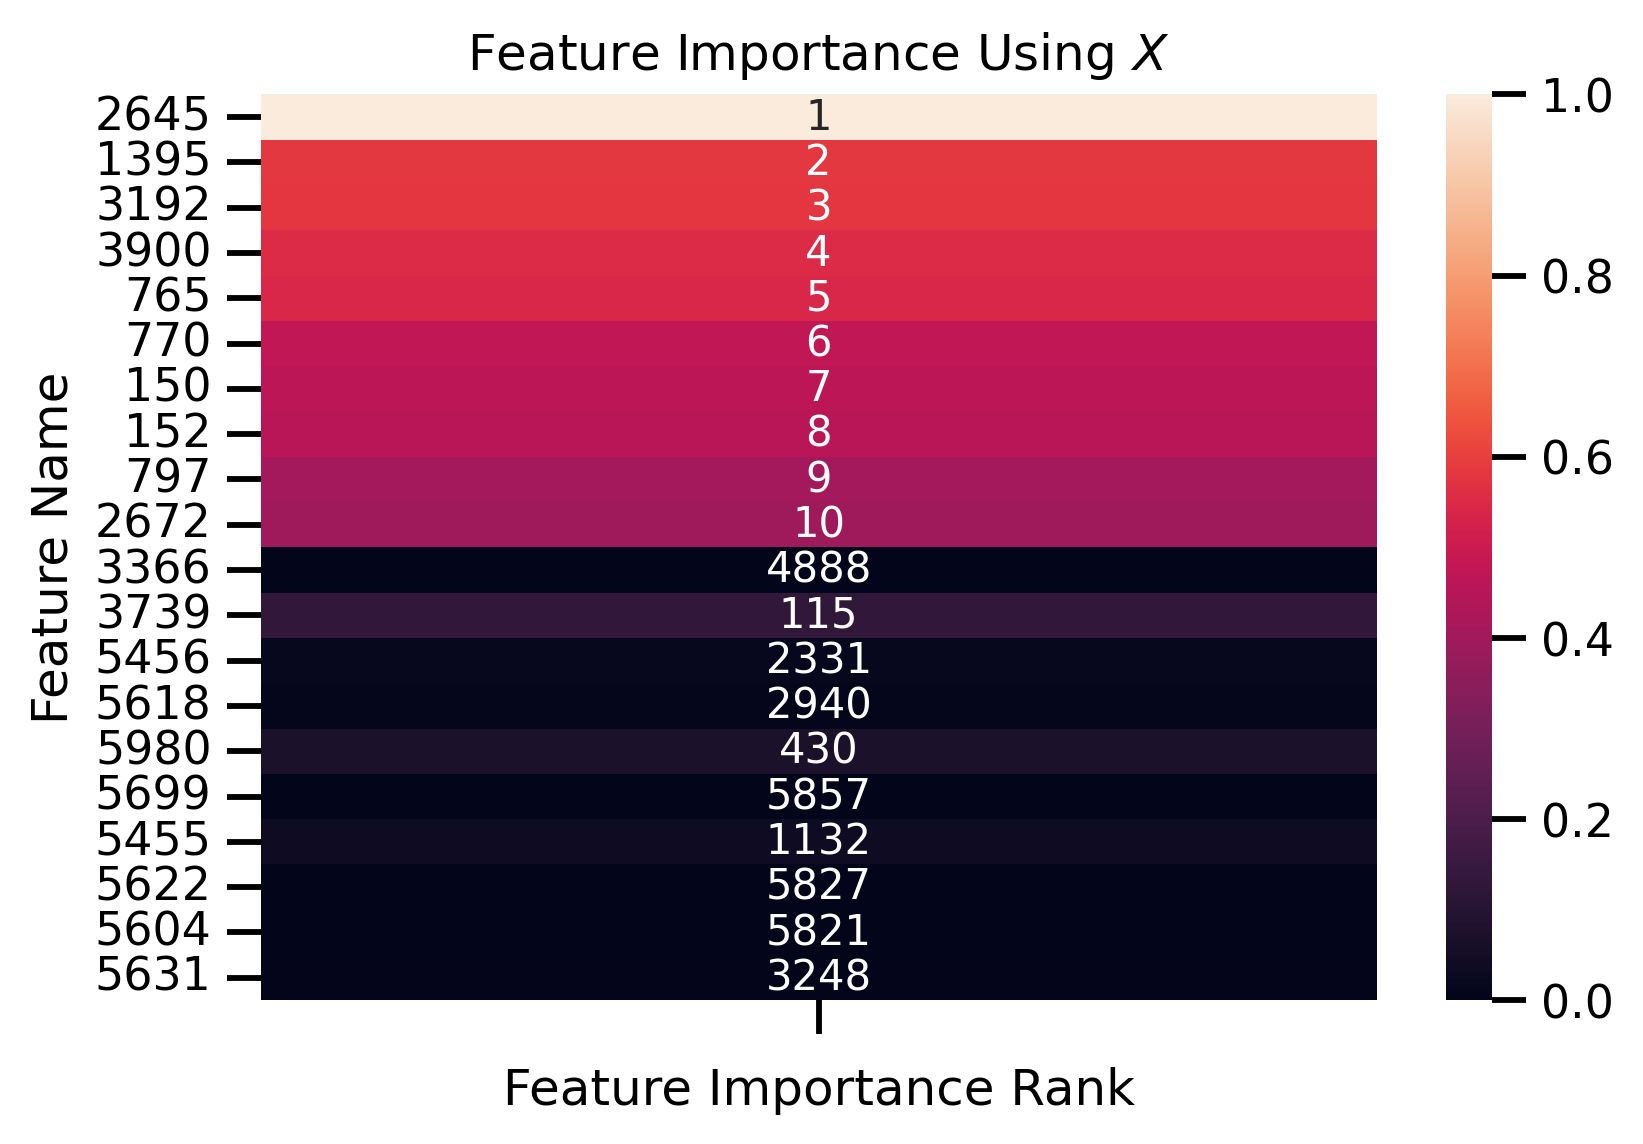

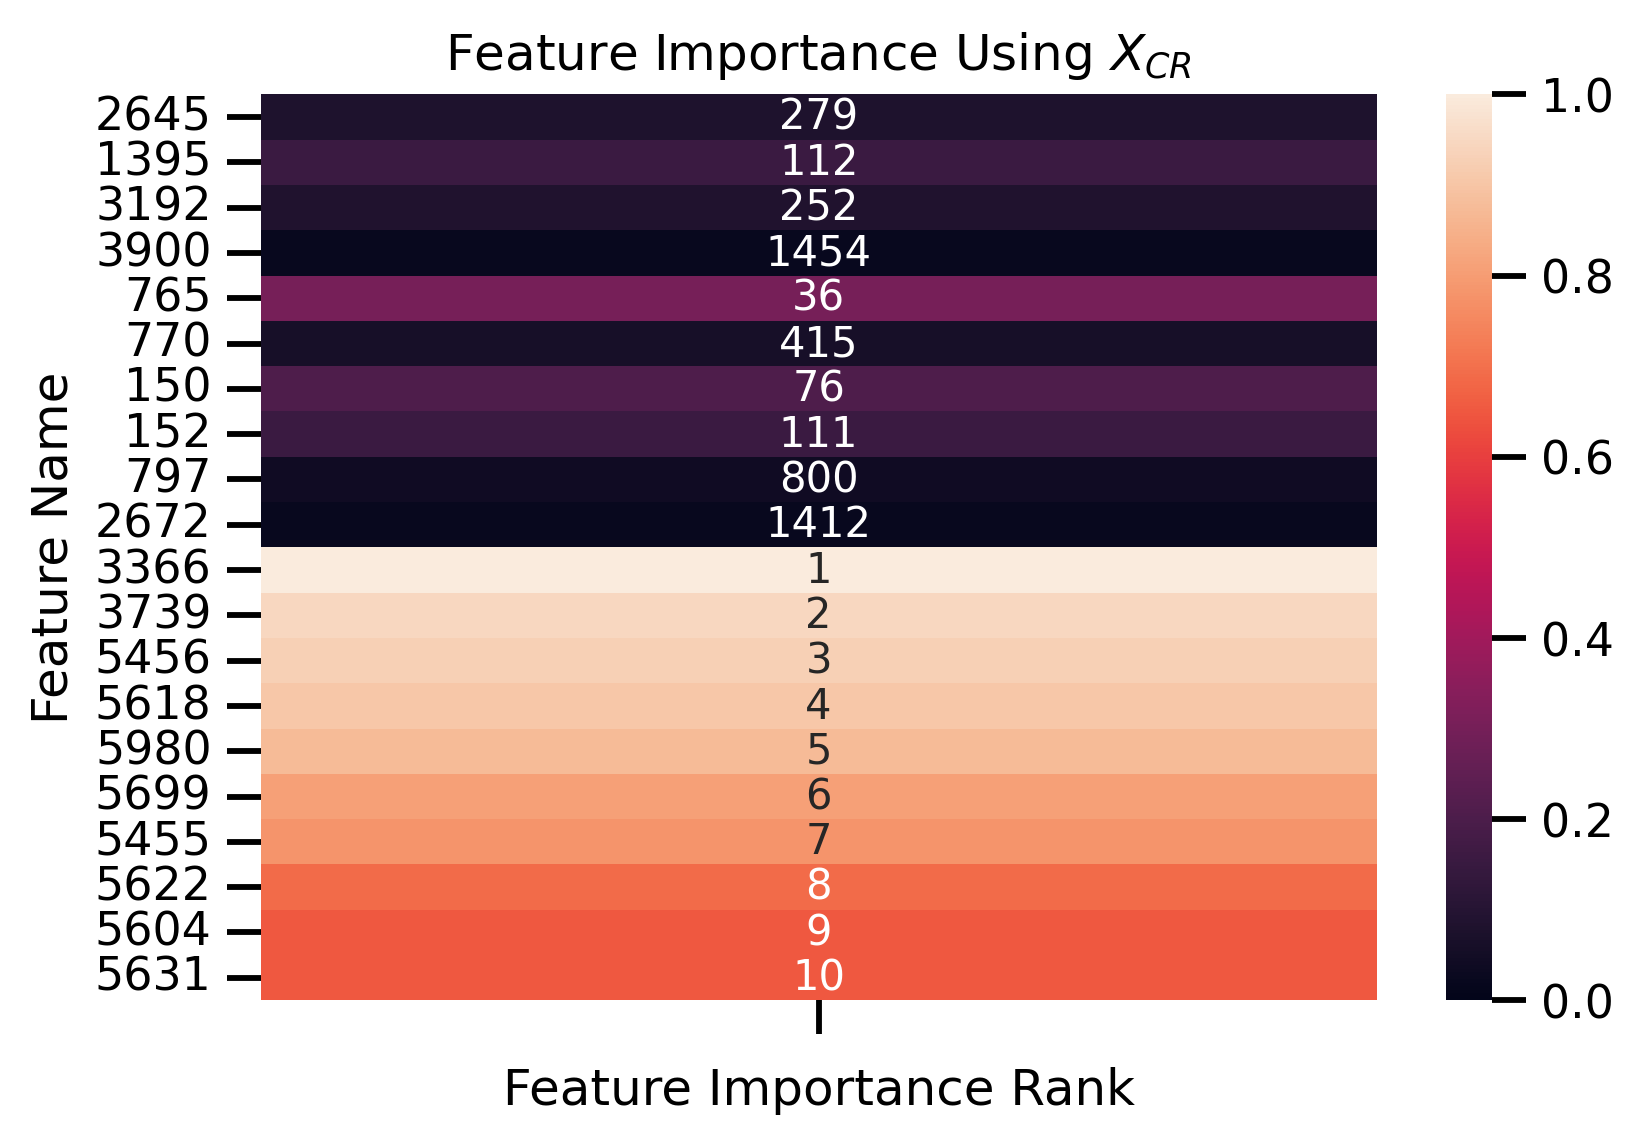

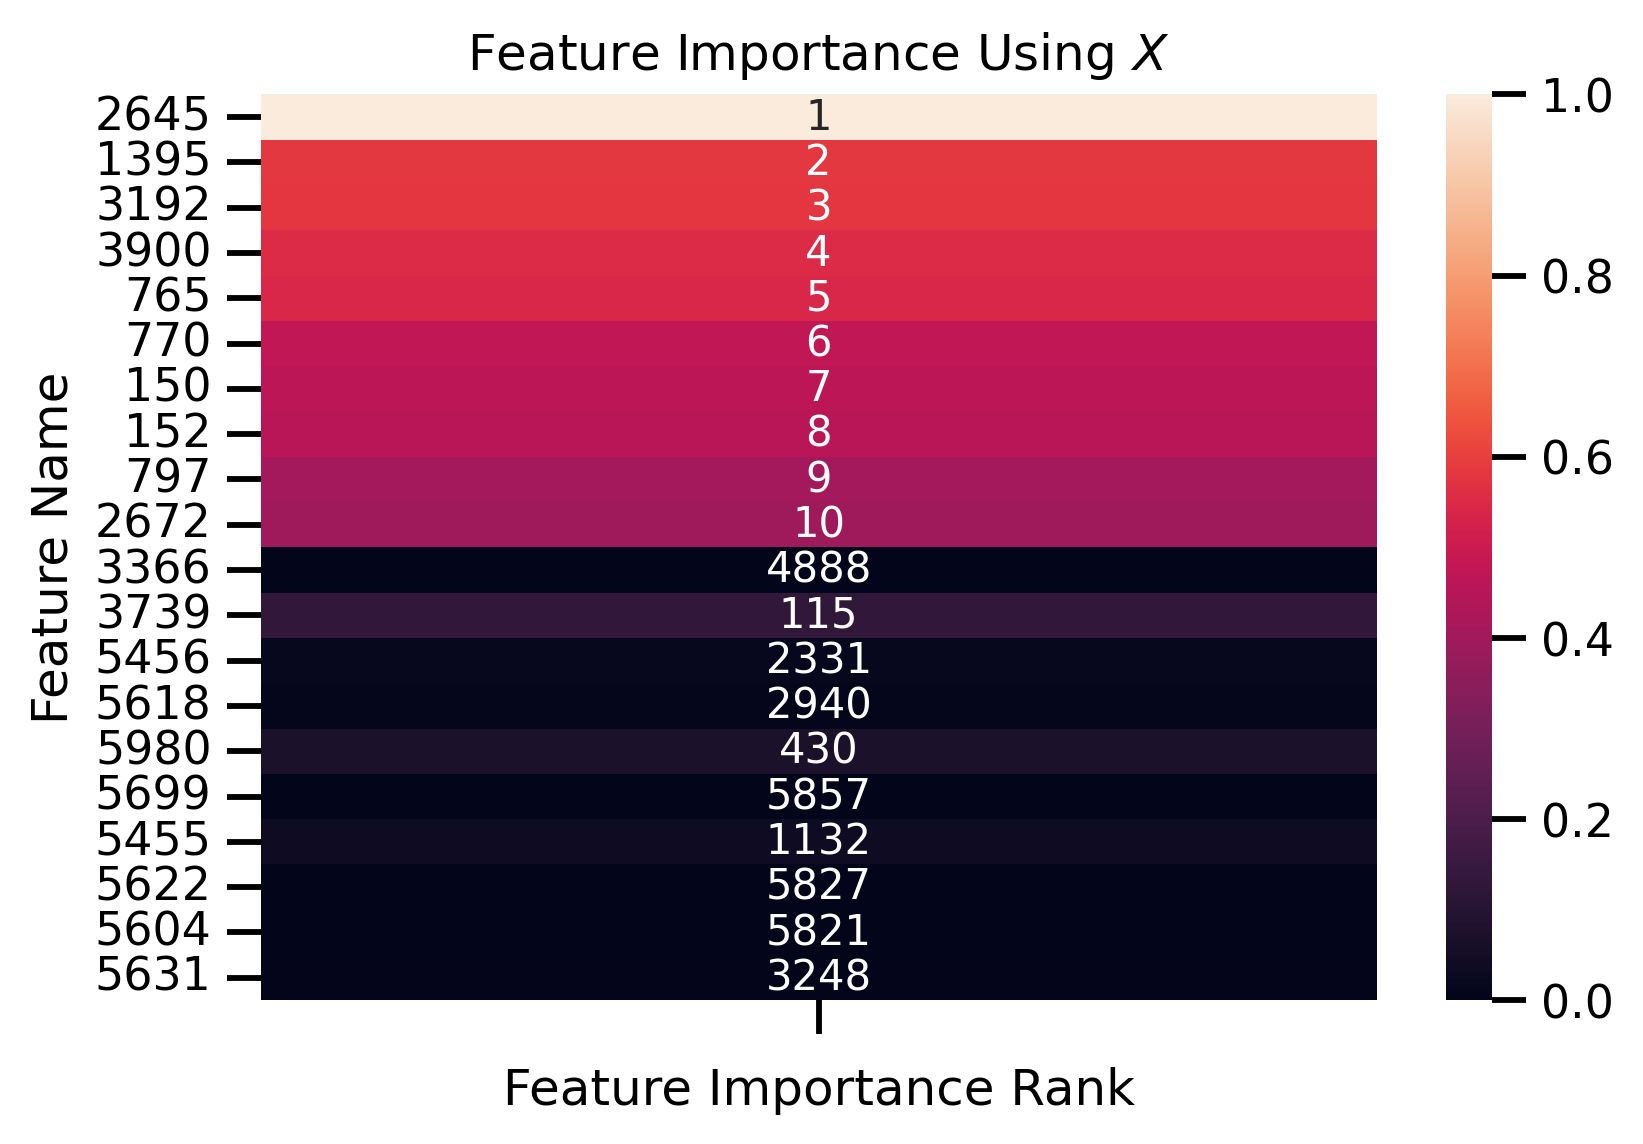

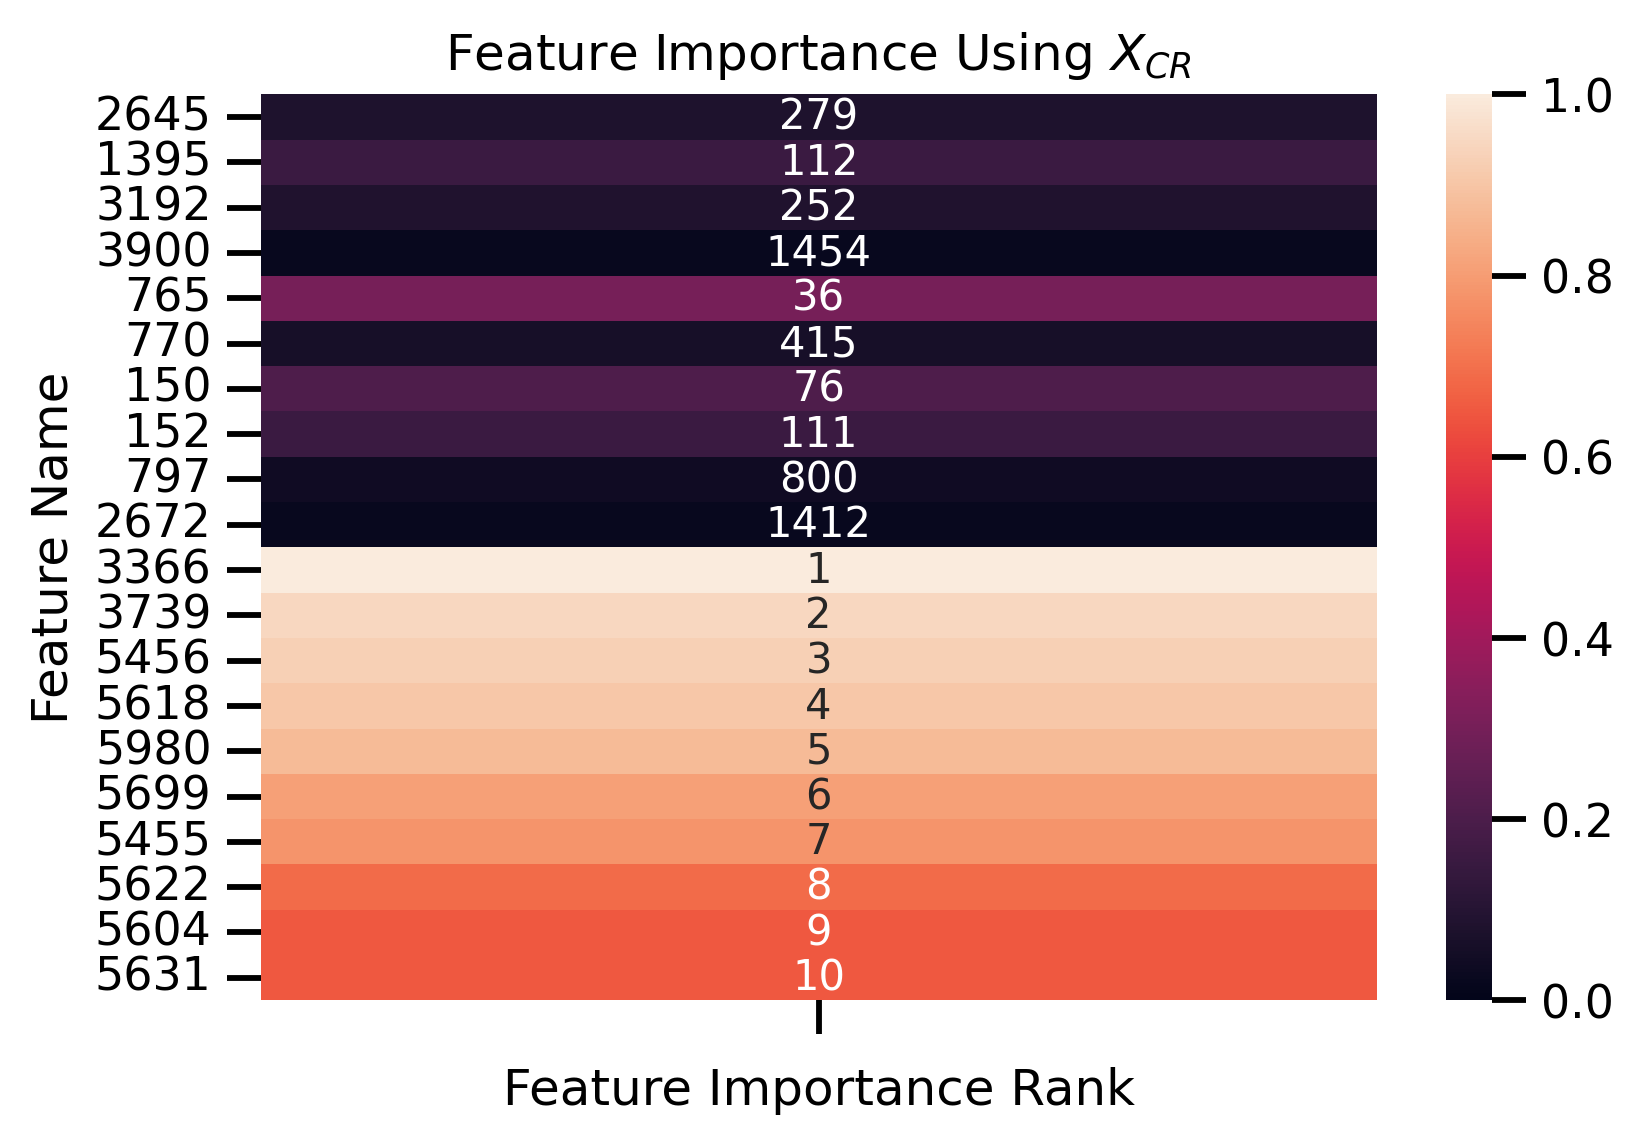

In [4]:
fig, ax = plt.subplots()
sns.heatmap(
    df_feat_heat_raw[["raw_original"]],
    annot=df_feat_heat_raw[["rank_raw"]],
    fmt=".5g",
    vmin=vmin,
    vmax=vmax,
    ax=ax,
    yticklabels=df_feat_heat_raw.index,
)
ax.set_title("Feature Importance Using $X$")
ax.set_ylabel("Feature Name")
ax.set_xticklabels([])
ax.set_xlabel("Feature Importance Rank")

fig.savefig("./saved_figures/feature_importance_raw.svg")
fig.savefig("./saved_figures/feature_importance_raw.png")
glue("raw_feature_importance", fig)

fig, ax = plt.subplots()
sns.heatmap(
    df_feat_heat_rem[["rem_original"]],
    annot=df_feat_heat_rem[["rank_rem"]],
    fmt=".5g",
    vmin=vmin,
    vmax=vmax,
    ax=ax,
    yticklabels=df_feat_heat_rem.index,
)
ax.set_title("Feature Importance Using $X_{CR}$")
ax.set_ylabel("Feature Name")
ax.set_xticklabels([])
ax.set_xlabel("Feature Importance Rank")

fig.savefig("./saved_figures/feature_importance_removed.svg")
fig.savefig("./saved_figures/feature_importance_remvoed.png")
glue("rem_feature_importance", fig)

Fit new decision tree only using most important removed features:

In [5]:
most_imp_feat_raw = [str(i) + "__continuous" for i in most_imp_feat_raw_10[:2]]
most_imp_feat_rem = [str(i) + "__continuous" for i in most_imp_feat_rem_10[:2]]

scores_raw, model_raw = run_cross_validation(
    X=most_imp_feat_rem,
    y=y,
    data=df_original,
    model=DecisionTreeClassifier(),
    preprocess_X=["zscore"],
    return_estimator="final",
    seed=42,
)
scores_rm, model_rm = run_cross_validation(
    X=most_imp_feat_rem,
    confounds=confounds,
    y=y,
    data=df_original,
    model=DecisionTreeClassifier(),
    preprocess_X=["zscore", "remove_confound"],
    return_estimator="final",
    seed=42,
)
print("RM:", scores_rm["test_score"].mean(), "Raw:", scores_raw["test_score"].mean())

# preprocess Features
Xcr, _ = model_rm.preprocess(df_original[most_imp_feat_rem + confounds], df_original[y])

Xraw, _ = model_raw.preprocess(df_original[most_imp_feat_rem], df_original[y])

RM: 0.7000615384615385 Raw: 0.611323076923077


Plot Raw

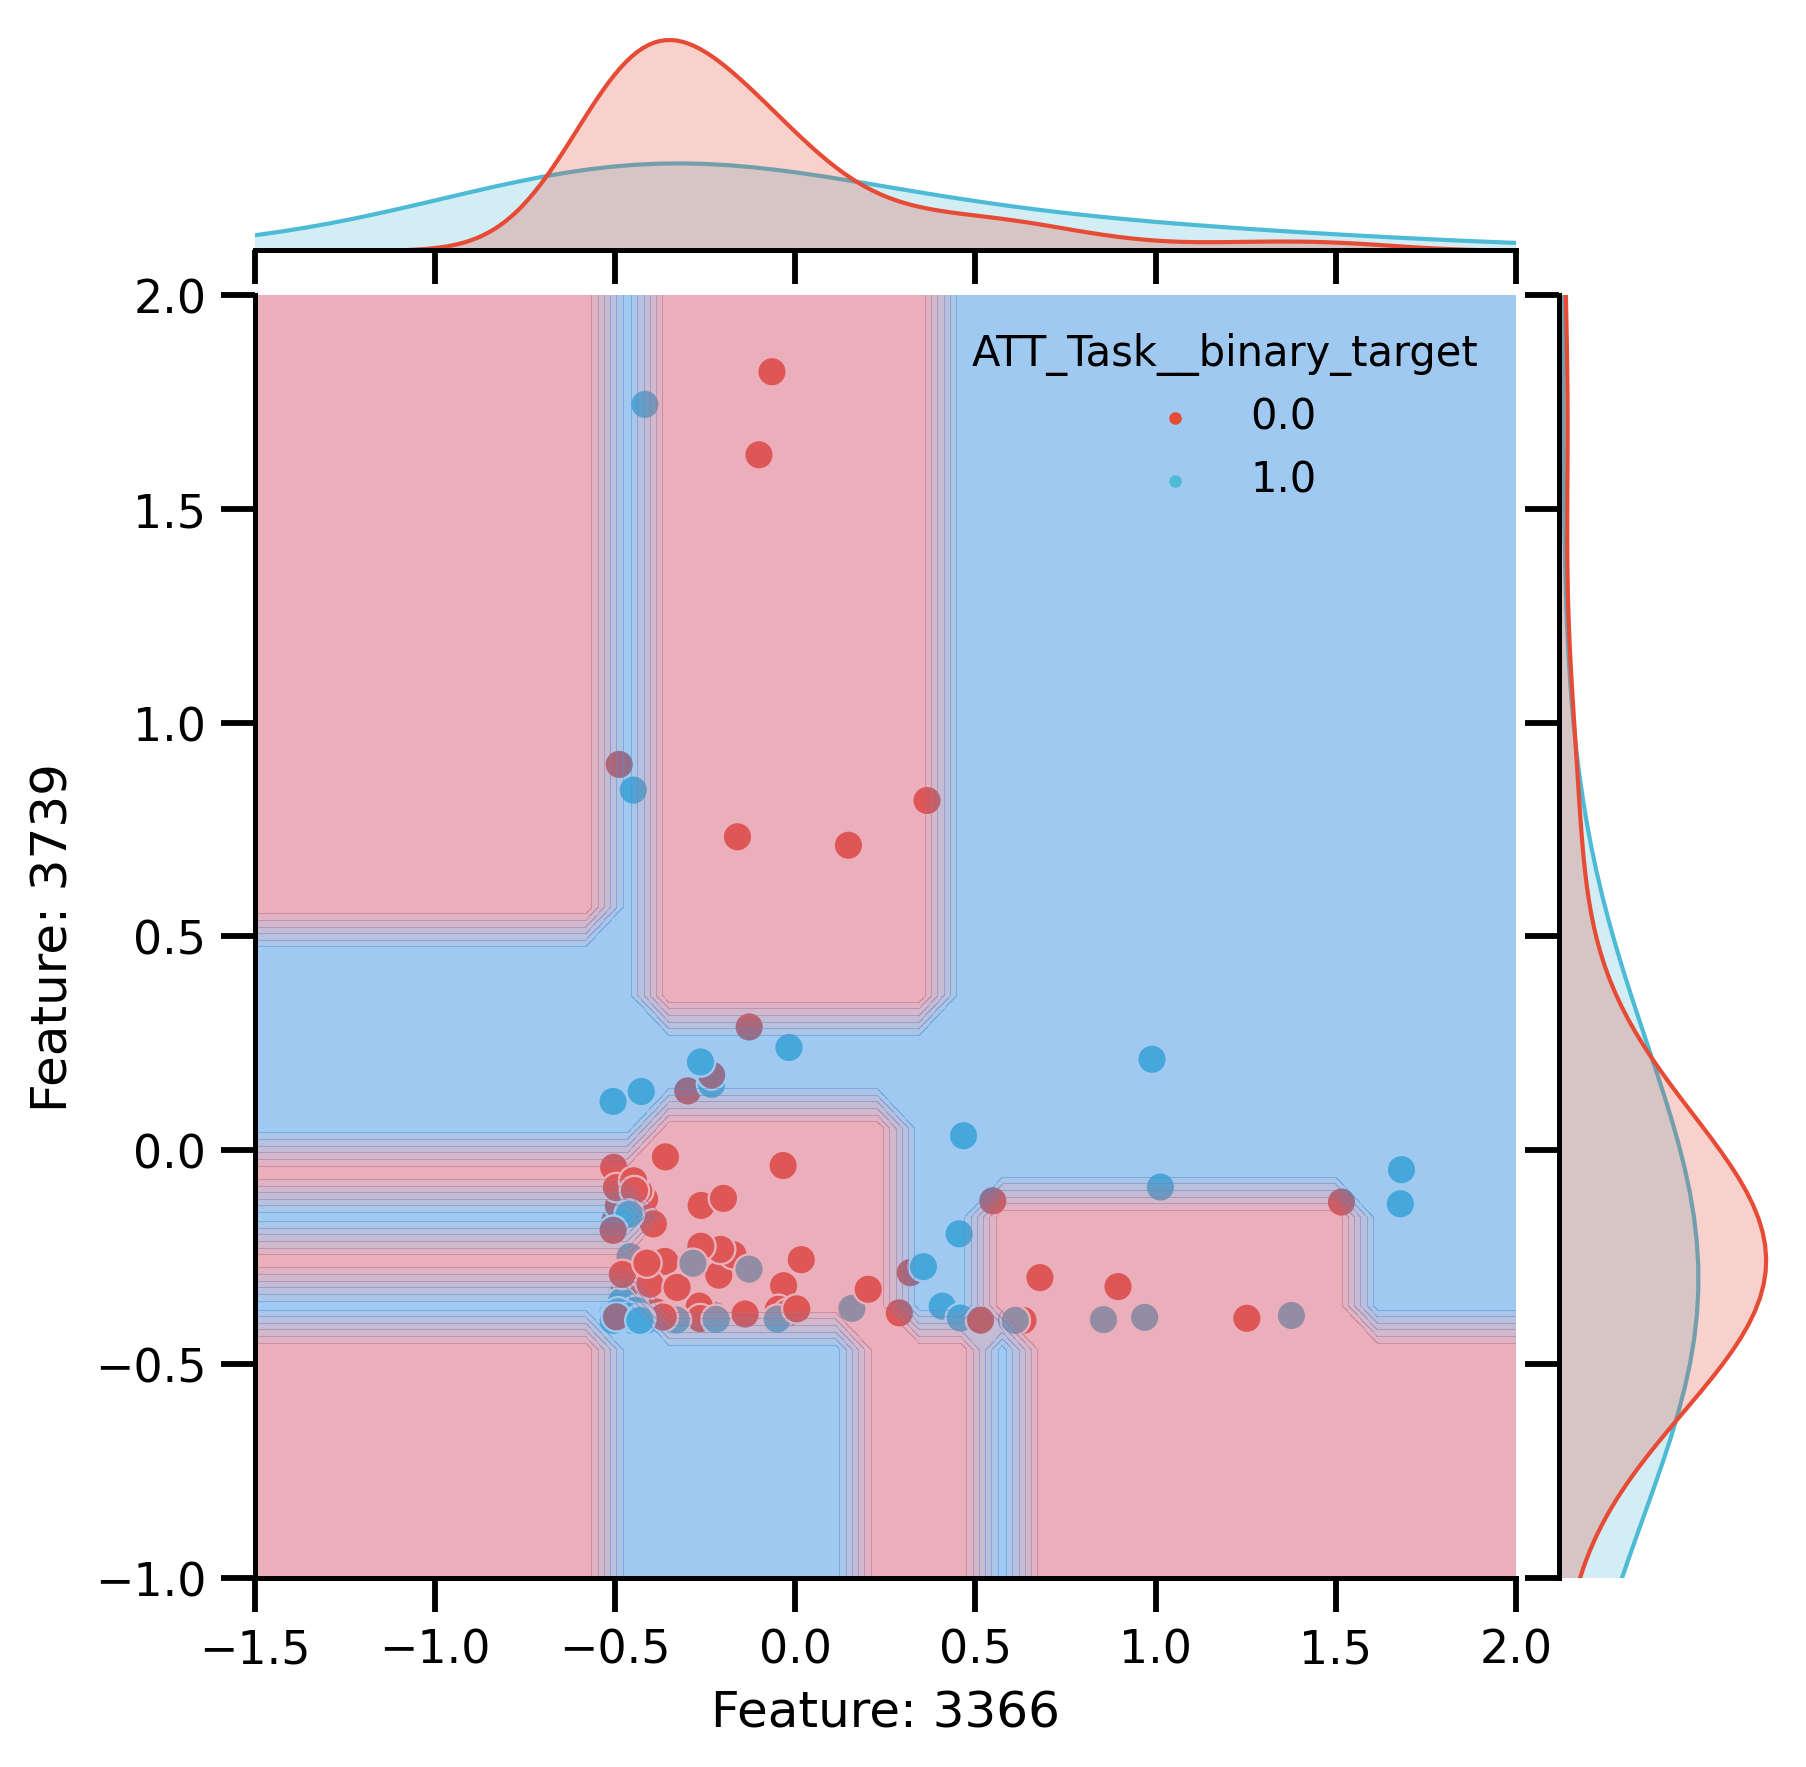

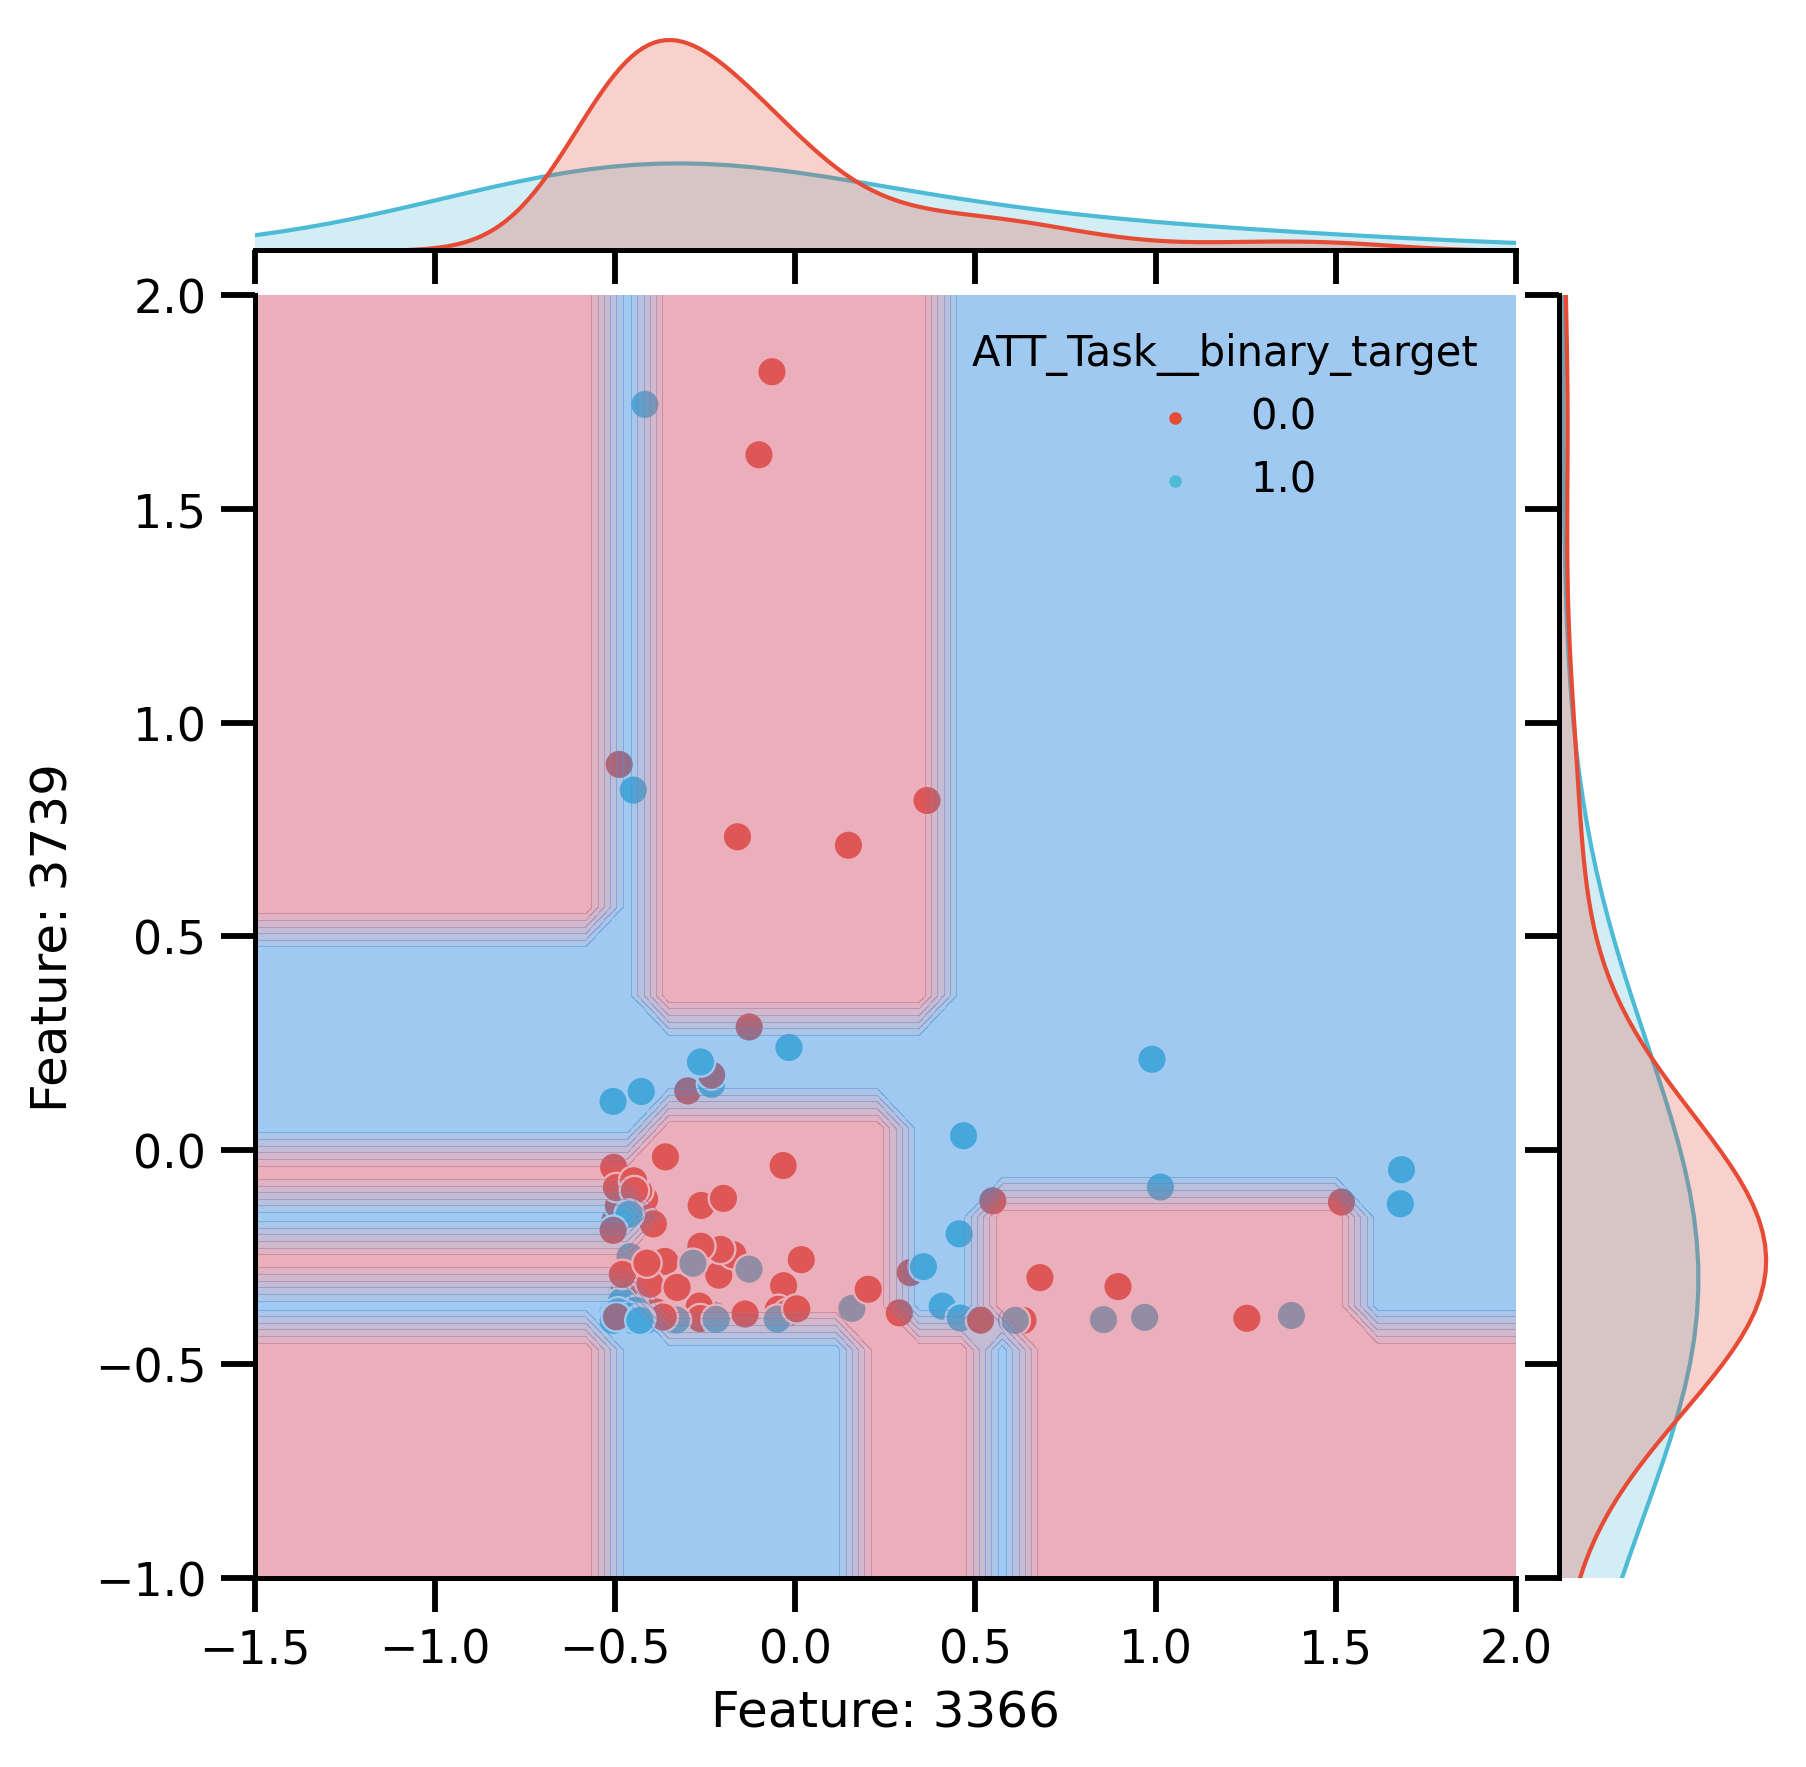

In [6]:
raw_plot = sns.jointplot(
    x=most_imp_feat_rem[0],
    y=most_imp_feat_rem[1],
    data=Xraw.assign(**{y: df_original[y]}),
    kind="scatter",
    hue=y,
    s=50,
)

DecisionBoundaryDisplay.from_estimator(
    model_raw.named_steps.decisiontreeclassifier,
    Xraw,
    ax=raw_plot.ax_joint,
    cmap=(LinearSegmentedColormap.from_list("MyCmapName", ["#e35d6d", "#3498eb"])),
    alpha=0.5,
)

raw_plot.ax_joint.set_xlim(-1.5, 2)
raw_plot.ax_joint.set_ylim(-1, 2)

raw_plot.ax_joint.set(
    xlabel="Feature: " + raw_plot.ax_joint.get_xlabel().split("_")[0],
    ylabel="Feature: " + raw_plot.ax_joint.get_ylabel().split("_")[0],
)
fig_raw_decision = raw_plot.fig
fig_raw_decision.savefig("./saved_figures/decision_boundary_feature_importance_raw.svg")
fig_raw_decision.savefig("./saved_figures/decision_boundary_feature_importance_raw.png")
glue("raw_decision", fig_raw_decision)

Plot after CR:

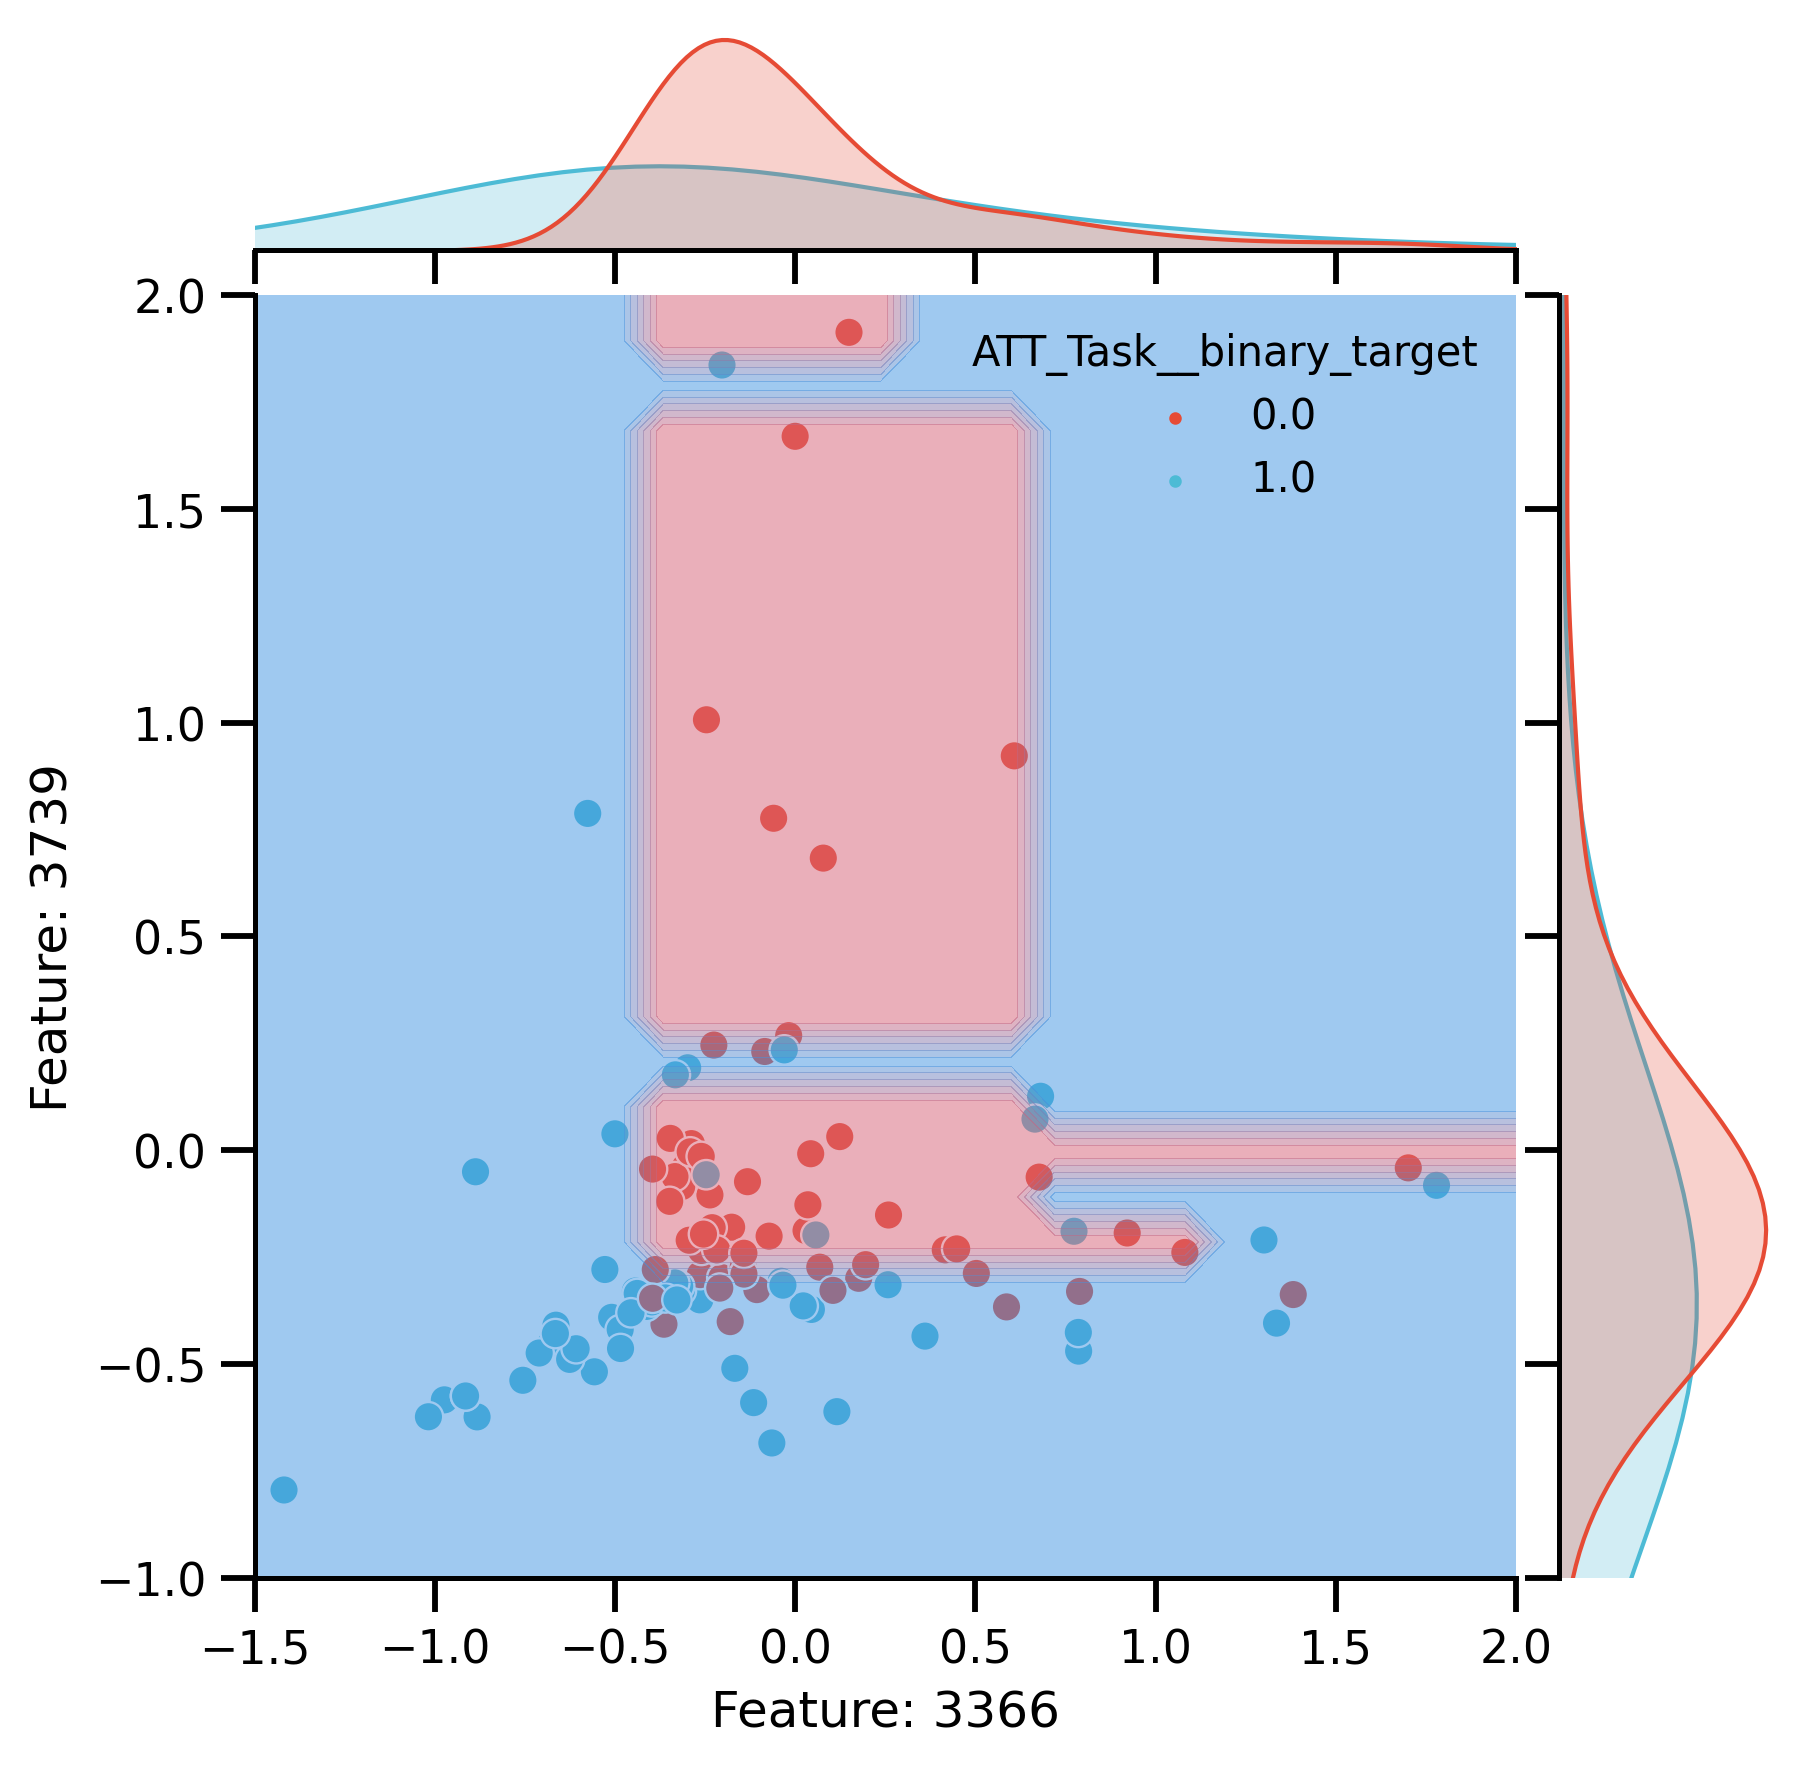

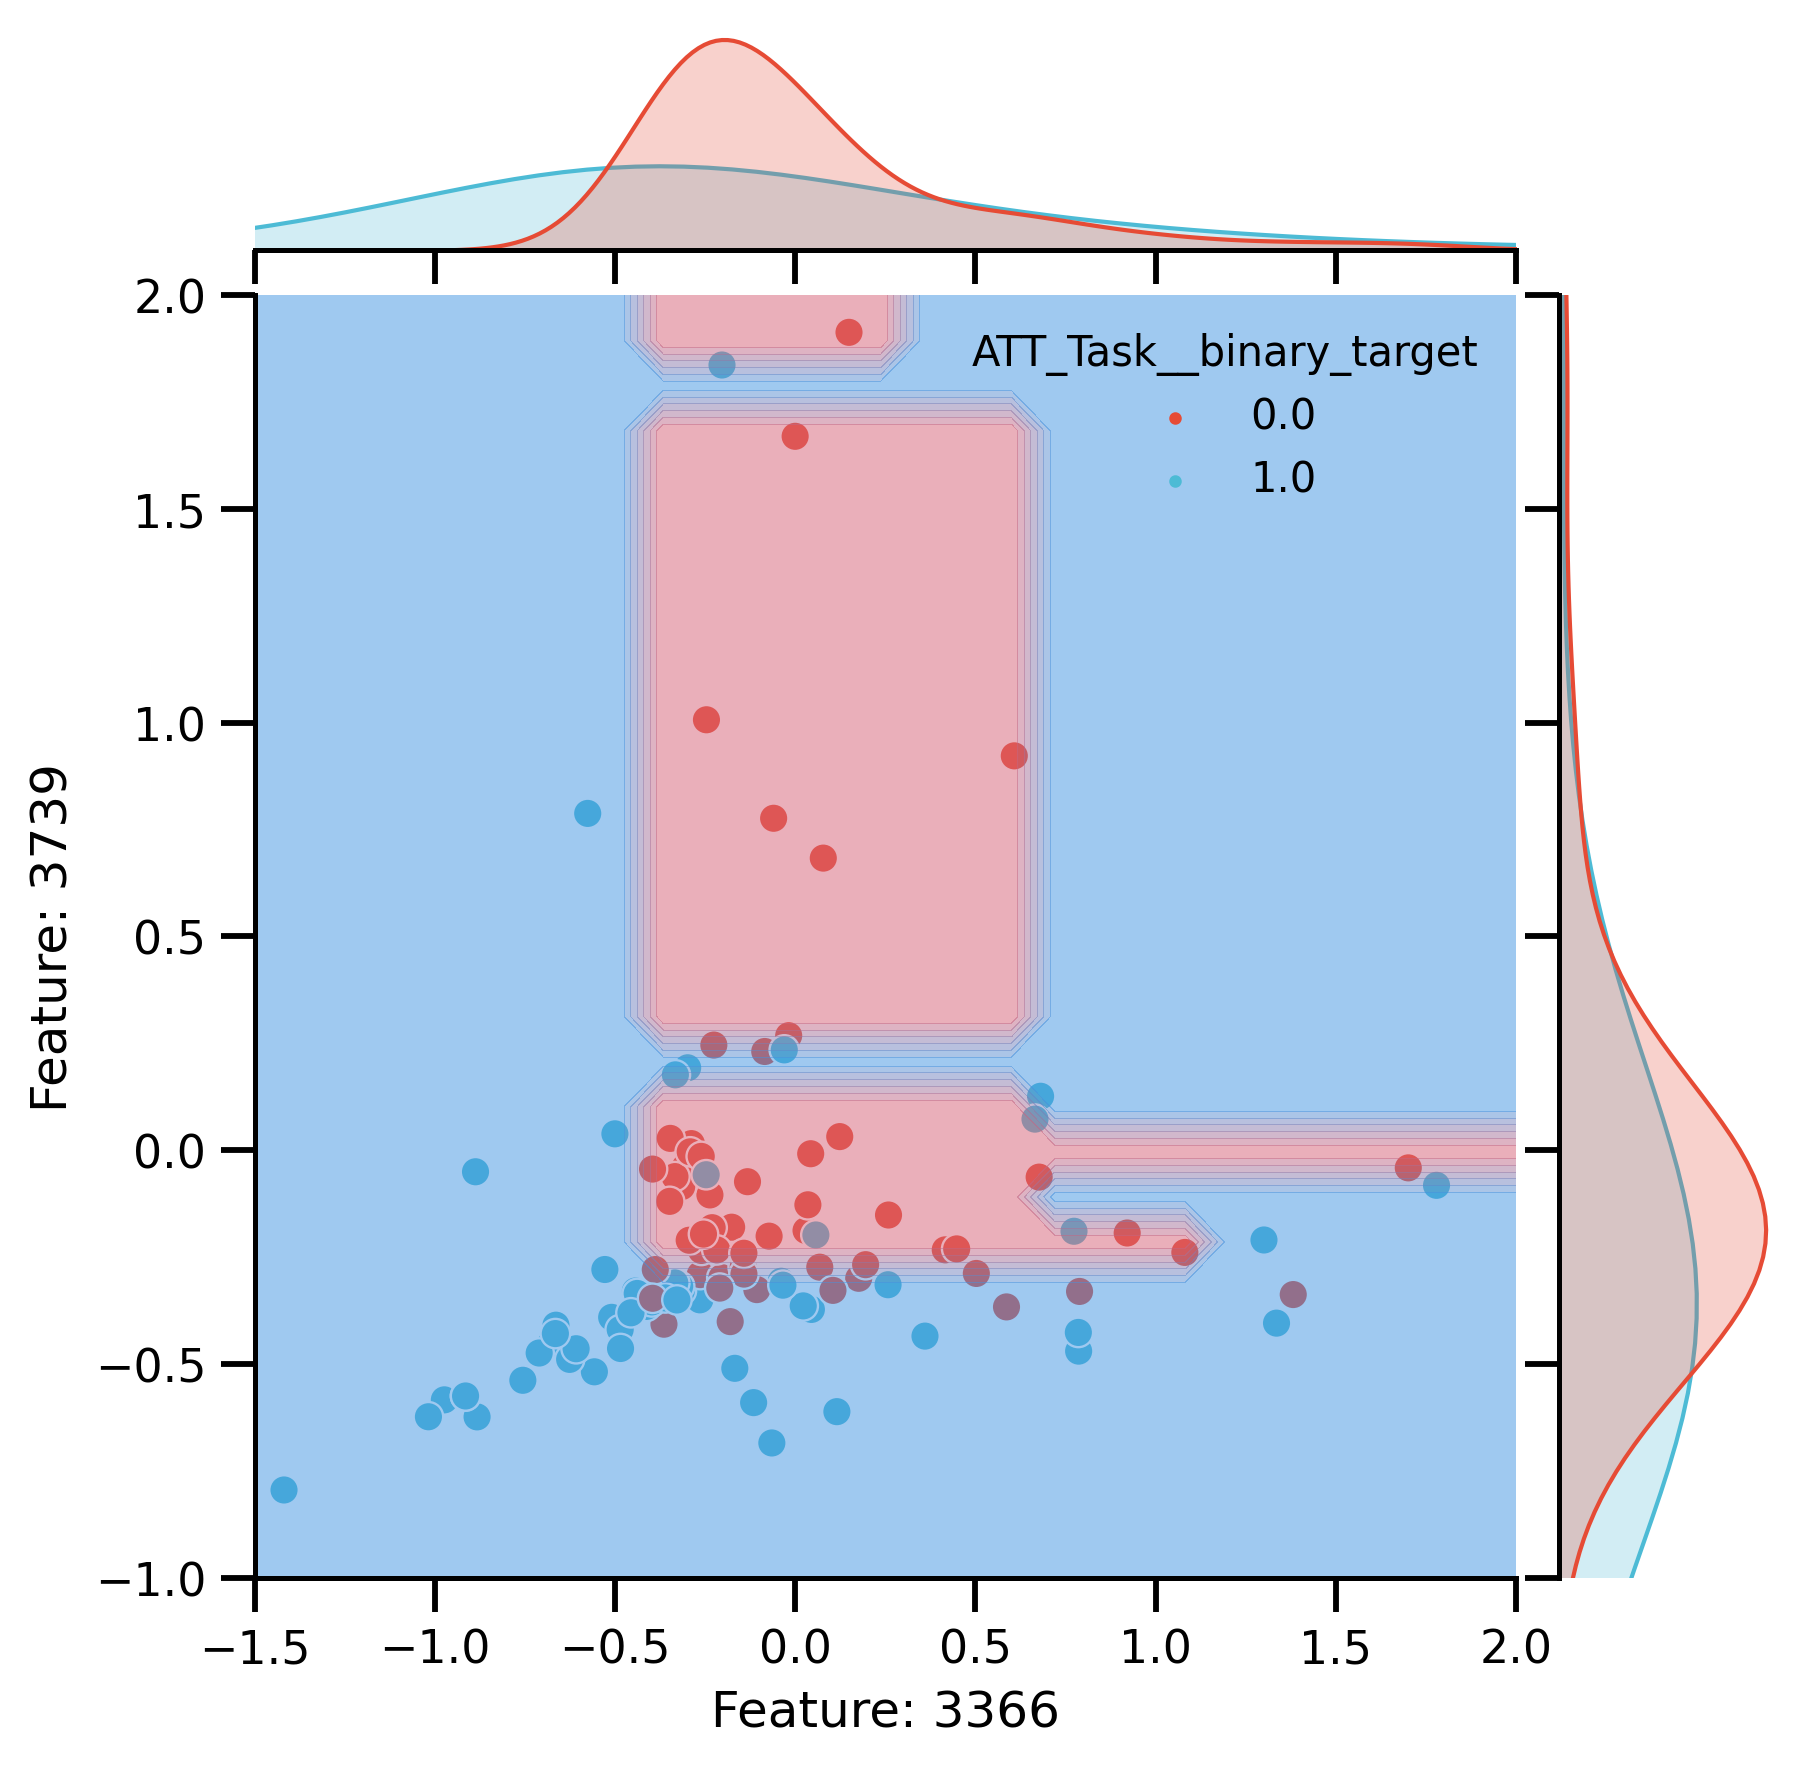

In [7]:
rem_plot = sns.jointplot(
    x=most_imp_feat_rem[0],
    y=most_imp_feat_rem[1],
    data=Xcr.assign(**{y: df_original[y]}),
    kind="scatter",
    s=50,
    hue=y,
)


rem_plot.ax_joint.set_xlim(-1.5, 2)
rem_plot.ax_joint.set_ylim(-1, 2)

DecisionBoundaryDisplay.from_estimator(
    model_rm.named_steps.decisiontreeclassifier,
    Xcr,
    ax=rem_plot.ax_joint,
    cmap=(LinearSegmentedColormap.from_list("MyCmapName", ["#e35d6d", "#3498eb"])),
    alpha=0.5,
)

rem_plot.ax_joint.set(
    xlabel="Feature: " + rem_plot.ax_joint.get_xlabel().split("_")[0],
    ylabel="Feature: " + rem_plot.ax_joint.get_ylabel().split("_")[0],
)

fig_rem_decision = rem_plot.fig
fig_rem_decision.savefig(
    "./saved_figures/decision_boundary_feature_importance_removed.svg"
)
fig_rem_decision.savefig(
    "./saved_figures/decision_boundary_feature_importance_removed.png"
)
glue("rem_decision", fig_rem_decision)


Features Importance

````{tabbed}  using original data 
```{glue:figure} raw_decision
:figwidth: 900px
```

````

````{tabbed}  using confounds 
```{glue:figure} rem_decision
:figwidth: 900px
```

````

Decision boundaries of DT trained on 2 most important:
Features.

````{tabbed}  using original data 
```{glue:figure} raw_decision
:figwidth: 900px
```

````

````{tabbed}  using confounds 
```{glue:figure} rem_decision
:figwidth: 900px
```
````